# Measuring Customer Lifetime Value (CLV) using lifetimes
####  This notebook powers the Medium article: Why CLV should be an Organization's North Star Metric.
#### Technical portions are denoted in *italics*

### Preamble and Thoughts on CLV
- What is CLV? CLV is the present value of future (net) cash flows associated with the customer. CLV is a forward-looking concept, not to be confused with (historic) customer profitability.
- There are multiple considerations when calculating CLV such as: What is the nature of the business? Is it contractual or non-contractual? What are the opportunities for transactions? Are they discrete or continuous? If the business is non-contractual and transactions are discrete such as charities, then you would use a model such as the Beta-Geometric/Beta-Binomal model vs. a non-contractual business with continuous transactions such as grocery purchases or doctor visits where a Beta-Geometric/Negative Binomial Distribution Model will be used.
- One challenge with looking at sales data in a non-contractual setting is how do we differentiate between customers who have ended their relationship with a company (i.e. stopped buying completely) vs. those who are in the midst of a long hiatus between transactions (those who buy 3-5x per year). And then how do you measure this for each customer since customer bases are heterogeneous by nature, meaning every single customer has a different CLV.
- The other challenge is trying to understand who our best customers are, why they're different from the rest, and trying to find more like them. Sales data by nature is historic and not indicative of the future. A customer who bought 4 times in the past isn't necessarily projected to buy 4 times in the future. And most certainly might not have the same order value.

## Table of Contents
1. Installation and Imports
2. Data Preparation
3. Understand Customer Behaviour
4. Predict Customer Transactions
5. Customer Lifetime Value

## 1. Installation and Imports

### Install Lifetimes Package
- lifetimes is a Python package developed by Cameron Davidson-Pilon that brings together the models needed to analyze our customer base to understand customer behaviour, purchasing patterns, and ultimately, Customer Lifetime Value.

- __[lifetimes Documentation](https://readthedocs.org/projects/lifetimes/downloads/pdf/latest/#page7)__

In [2]:
pip install lifetimes

Note: you may need to restart the kernel to use updated packages.


### Install Pandas Profiling Package
- Pandas Profiling is a Python package that helps us quickly analyze our data

In [3]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


### Import CLV Models

- Refer to the following literature for full technical details and descriptions of these models:
    - __[Probability Models for Customer-Base Analysis](https://www.brucehardie.com/talks/ho_cba_tut_art_09.pdf)__
    - __[Buy ’Til You Die - A Walkthrough](https://cran.r-project.org/web/packages/BTYD/vignettes/BTYD-walkthrough.pdf)__

In [4]:
#BG/NBD (Beta-Geometric/Negative Binomial Distribution Model) model for predicting transactions of non-contractual continuous customer bases
from lifetimes import BetaGeoFitter
#GammaGamma model for predicting conditional expected average CLV
from lifetimes import GammaGammaFitter

### Import CLV Plots, Utility Functions and Profiling
- Full description of what each plot is can be found on Page 24 from the documentation

In [5]:
from lifetimes.plotting import *
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from pandas_profiling import ProfileReport

### Bring in some other important tools
- Standard data and plotting tools

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

### Import Online Retail Transactional Data
- The data set is sourced from University of California Irvine in their Machine Learning Repository. 

- __[Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)__

In [7]:
#Import Data
data1 = pd.read_excel (r'/Users/williamchan/Documents/Queens University /Chanalytics/CLV/Data/online_retail.xlsx', 
                       sheet_name = 'Year 2009-2010')
data2 = pd.read_excel (r'/Users/williamchan/Documents/Queens University /Chanalytics/CLV/Data/online_retail.xlsx', 
                       sheet_name = 'Year 2010-2011')

## 2. Data Preparation and Quick Profiling

### Data Columns - Transactional Data
- We bring in the relevant information required to analyze CLV for each customer. Once we generate the CLV metrics, we'll rejoin those columns into this dataset for further analysis.

In [8]:
#Gather Quick Info
data1.info

<bound method DataFrame.info of        Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID         Country  
0 

In [9]:
#Gather Quick Info
data2.info

<bound method DataFrame.info of        Invoice StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3       536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4       536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...        ...       ...                                  ...       ...   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909  581587      POST                              POSTAGE         1   

               InvoiceDate  Price  Customer ID         Country  
0 

In [10]:
data1.tail(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525451,538171,22748,POPPY'S PLAYHOUSE KITCHEN,2,2010-12-09 20:01:00,2.10,17530.0,United Kingdom
525452,538171,22745,POPPY'S PLAYHOUSE BEDROOM,2,2010-12-09 20:01:00,2.10,17530.0,United Kingdom
525453,538171,22558,CLOTHES PEGS RETROSPOT PACK 24,4,2010-12-09 20:01:00,1.49,17530.0,United Kingdom
525454,538171,21671,RED SPOT CERAMIC DRAWER KNOB,6,2010-12-09 20:01:00,1.25,17530.0,United Kingdom
525455,538171,20971,PINK BLUE FELT CRAFT TRINKET BOX,2,2010-12-09 20:01:00,1.25,17530.0,United Kingdom
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [11]:
data2.tail(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0,France
541902,581587,22629,SPACEBOY LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
541909,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [12]:
#Union both dataframes
frames = [data1, data2]
data = pd.concat(frames)

In [13]:
#Calculate Total Sale
data["total_sale"] = data["Quantity"] * data["Price"]

In [14]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_sale
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [15]:
#Convert DateTime to Date only
data['date'] = pd.to_datetime(data['InvoiceDate']).dt.date

In [16]:
data['Invoice'] = data['Invoice'].astype(str)

In [17]:
#Profile the data for missing values, skewness
profile = ProfileReport(data)
profile.to_file(output_file='output.html')

In [18]:
#Drop NAs based off data profiling
data.dropna(subset = ["Customer ID"], inplace=True)

In [19]:
#Rename columns for proper nomenclature
data.rename(columns={"Invoice": "invoice", 
                     "StockCode": "stockcode", 
                     "Description": "description", 
                     "Quantity": "quantity", 
                     "InvoiceDate": "invoice_date", 
                     "Price": "price", 
                     "Customer ID": "customer_id", 
                     "Country": "country"}, inplace=True)

In [20]:
# Filter out all elements that start with 'C'
data = data[(data['quantity'] > 0)]

In [21]:
#check if previous code was applied
data.info

<bound method DataFrame.info of        invoice stockcode                          description  quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
541905  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909  581587      POST                              POSTAGE         1   

              invoice_date  price  customer_id         country  tot

In [22]:
#find min date
min(data.date)

datetime.date(2009, 12, 1)

In [23]:
#find max date
max(data.date)

datetime.date(2011, 12, 9)

### Utility Functions - Going from Transactional to Summary
- lifetimes has utility functions that can transform transactional-level data into the data shape we need to fit our models

In [24]:
#This utility transforms our transaction-level data into the summary format needed for our models!
summary = summary_data_from_transaction_data(data, 'customer_id', 'date', 'total_sale', datetime_format = '%Y-%m-%d', freq = 'D', observation_period_end = '2011-12-09')

### Data Columns - Summary Data
- customer_id: Unique Customer ID
- Frequency: The number of repeat purchases during the time period we are analyzing. A low frequency (low repeat purchases) means a customer bought minimally from us. A high frequency (multiple repeat purchases) means a customer bought frequently from us. In a case where a customer made only 1 purchase, their frequency will be 0. If a customer made 2 purchases on day 1 and 3 purchases on day 3, their frequency will still be 1 despite multiple daily purchases. This results in a single repeat purchase.
- Recency: The age (time period) of a customer when they made their most recent purchase. This is measured by the duration between a customer's first purchase and their latest purchase. If a customer made 1 purchase then their recency will be 0.
- T: The customer's age (time period), which is the duration between a customer's first purchase and the end of the data set's time period
- Monetary_value: represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [25]:
#BAM! We have our summary data needed for our models
print(summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
12346.0            7.0    400.0  725.0    11066.637143
12347.0            7.0    402.0  404.0      717.398571
12348.0            4.0    363.0  438.0      449.310000
12349.0            3.0    571.0  589.0     1120.056667
12350.0            0.0      0.0  310.0        0.000000


### Data Understanding
- Let's understand our data set a bit more by seeing how many customers there are. We also need to understand how many customers are one-time buyers. According to our distribution below, it appears that 28% of our customers buy from us only once, meaning 3 in 4 customers are repeat buyers. A good sign.

count    5881.000000
mean        4.630335
std        10.001176
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max       254.000000
Name: frequency, dtype: float64
-----------------------------------------
Percentage of customers who purchase once only (i.e. one-time buyers): 28.77 %


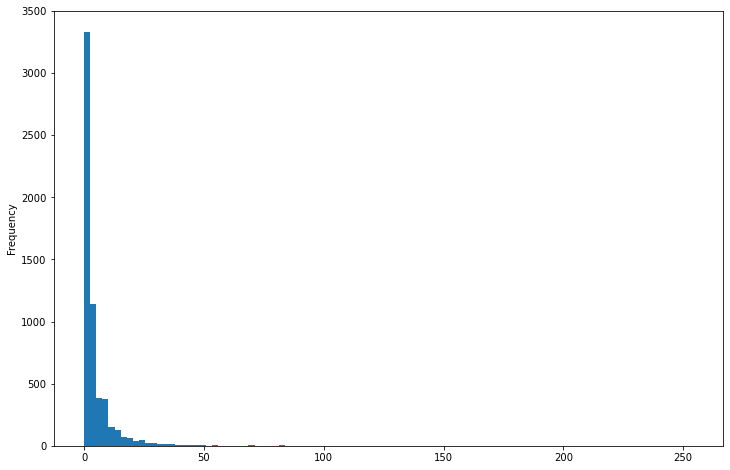

In [26]:
plt.figure(figsize=(12, 8))
summary['frequency'].plot(kind='hist', bins = 100)
print(summary['frequency'].describe())
print("-----------------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers who purchase once only (i.e. one-time buyers):", one_time_buyers, "%")

In [27]:
# retain only those customers with frequency > 0
summary = summary[summary['frequency'] > 0]

### Initialize our Model
- *In small sample sizes, the model parameters can get large and expand out of control. The `penalize_coef` is there to help control overfitting so that our model can generalize well. L2 regularization forces the weights to be small but does not make them zero. In other words, `penalizer_coef` is the coefficient applied to an l2 normalization on the model's parameters to shrink them. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.  Since our sample is large enough and robust, we'll leave it at 0.*

In [28]:
#BG/NBD model for predicting transactions of non-contractual continuous customer bases
bgf = BetaGeoFitter(penalizer_coef=0.001)

#### BG/NBD Model Assumptions
1. *The number of transactions from an active customer can be described using a Poisson distribution where t = time and the rate = lambda*
2. *Purchasing behaviour is different among customers and has a Gamma distribution - modeled `r` for shape parameter and `alpha` for scale parameter*
3. *Customers can become inactive (stop buying from us) after any transaction. Their inactive point is distributed between purchases with a Geometric distribution and measured using `p`*
4. *Heterogeneity in dropout probability has a beta distribution - modeled by `a` and `b`*
5. *Transaction rates and dropout probabilities vary independently across user*

### Fit the BG/NBD Model
- The Beta Geometric / Negative Binomial distribution model (BG/NBD) requires only three data elements to fit the model. `frequency`, `recency` and `T`.
- *`r` and `alpha` describe the heterogeneity in transaction rates across customers (i.e., how customers are different in their purchasing behaviour). `a` and `b` describe the heterogenity in dropout rates across customers (i.e., what is the likelihood of a customer dropping out after a purchase). The charts below help us understand the heterogeneity of our customer base.*

In [29]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4189 subjects, a: 0.10, alpha: 103.35, b: 0.97, r: 1.52>

In [30]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.518839,0.040481,1.439497,1.598180
alpha,103.350418,3.185288,97.107253,109.593583
a,0.095663,0.008748,0.078518,0.112808
b,0.969228,0.115161,0.743512,1.194945


#### Gamma Distribution Histogram
- *These are the customers' propensity to purchase as estimated by lambda from the Gamma Distribution. The Gamma distribution is widely used to model continuous variables that are always positive and have skewed distributions.*

<AxesSubplot:title={'center':'mean: 0.015, var: 0.000'}, xlabel='Transaction Rate', ylabel='Density'>

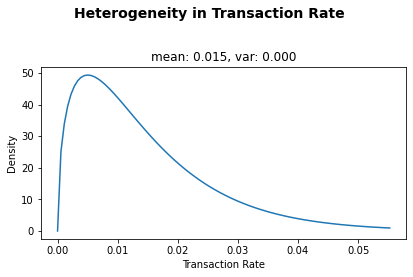

In [31]:
#plot the estimated gamma distribution of lambda (customers' propensities to purchase)
plot_transaction_rate_heterogeneity(bgf)

#### Beta Distribution Histogram
- *These are the customers' probabilities of dropping out immediately after a transaction. It's modeled using a Beta distribution (p). A Beta distribution is used to model things that have a limited range, like 0 to 1. Examples are the probability of success in an experiment having only two outcomes, like success and failure. In this case, the probability of a customer not returning for a subsequent purchase.*

<AxesSubplot:title={'center':'mean: 0.090, var: 0.040'}, xlabel='Dropout Probability p', ylabel='Density'>

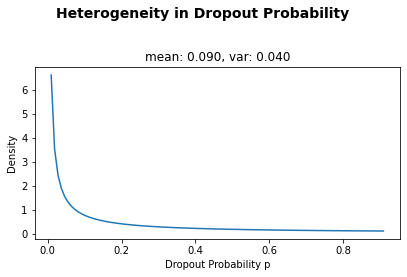

In [32]:
#plot the estimated beta distribution of p, a customers' probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(bgf)

## 3. Understand Customer Behaviour

### Visualizing our Frequency/Recency Matrix

#### CHART #1: Expected Number of Future Purchases
- The chart below plots the number of transactions a customer is projected to have in the next 30 days.
- We notice on the bottom right, customers who bought recently, and who bought frequently over the data set period are expected to have the highest number of purchases (8+) over the next 30 days. This small highligted group represents our BEST customers.
- Basically, customers who made multiple repeat purchases but with a **smaller** time difference (lower recency) between their first purchase and their most recent are likely to have disappeared and won't return. (i.e., buying a lot in a small time period)
- Customers who made multiple repeat purchases but with a **larger** time difference (higher recency) between their first purchase and their most recent are likely to be your best customers in the future. (i.e., buying a lot and over a larger time period)
- Customers in the green-blue-ish area are still likely to make 4-8 purchases in the next 12-months. This group might need a promotion or activation to get them going.

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

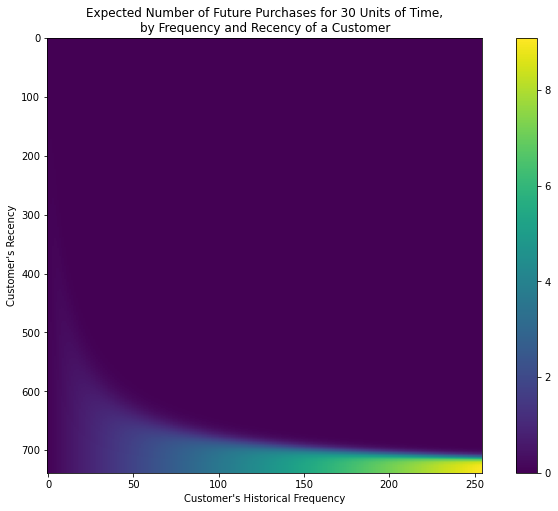

In [33]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf, T = 30)

#### CHART #2: Probability of a Customer Being "Alive"
- The chart below plots the probability of our customer being "alive" based on their repeat purchases (frequency) and recency. Intuitively, we notice that customers with a high recency (recent last repeat purchase) have the highest probability of being "alive", despite how many purchases they have.
- Interestingly enough, if we look across a fixed recency point like 30 and across different frequencies, we notice that customers with the same recency (600) but higher frequency have lower probabilities of being "alive". This is not mistake, and in fact a property of the model which illustrates the importance of recency.
- Customers who higher amount of repeat purchases, but who don't make them ongoing as time passes (recency) are more likelier to disappear from us as time passes. Basically, they bought a ton from you early on, got what they need, and you never saw them again. Example: Think of home furniture after you move, you'll buy a ton of furniture, couches, chairs, tables, carpets in a condensed period of time, but will probably not return for awhile since you'll have all you need.

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

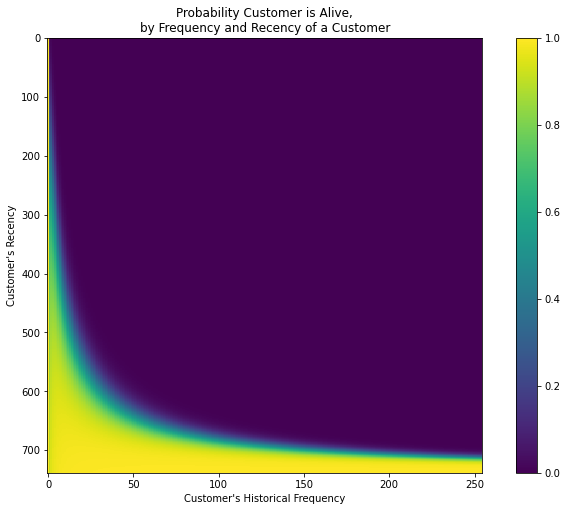

In [34]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

## 4. Predict Customer Transactions

### Predict a customer's total transactions in the next 365 days
- Next we'll predict the total purchases our customers will make at the individual-level for the next 12 months

### Train/Test Split
- We'll split our data into train and test and then refit the bgf model to see how it performs against unseen data

In [35]:
#Using the transactional data we can do things like holdout (train and test)
data_cal_holdout = calibration_and_holdout_data(data, 'customer_id', 'date', monetary_value_col = 'total_sale', freq = 'D',
                                               calibration_period_end = '2010-12-31',
                                               observation_period_end = '2011-12-09')
data_cal_holdout.head(10)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
12346.0,6.0,196.0,382.0,47.143333,1.0,77183.600000,343.0
12347.0,1.0,37.0,61.0,1423.580000,6.0,23.829205,343.0
12348.0,1.0,80.0,95.0,892.800000,3.0,64.602857,343.0
12349.0,2.0,182.0,246.0,801.310000,1.0,24.076027,343.0
12351.0,0.0,0.0,32.0,0.000000,0.0,0.000000,343.0
12352.0,1.0,17.0,49.0,200.050000,7.0,29.482824,343.0
12353.0,0.0,0.0,65.0,0.000000,1.0,22.250000,343.0
12355.0,0.0,0.0,224.0,0.000000,1.0,35.338462,343.0
12356.0,2.0,44.0,81.0,1325.905000,3.0,47.651356,343.0


### Refit the Model with Train/Test
-  We'll re-fit our model with the trained data and to see how it predicts against unseen data

In [36]:
#BG/NBD model for predicting transactions of non-contractual continuous customer bases
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [37]:
#Fit the Model
bgf.fit(data_cal_holdout['frequency_cal'], data_cal_holdout['recency_cal'], data_cal_holdout['T_cal'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.830871,0.026371,0.779185,0.882557
alpha,72.469405,2.701931,67.173619,77.765191
a,0.005760,0.003847,-0.001780,0.013300
b,0.548897,0.242213,0.074159,1.023634


In [38]:
#Set t to 365+22 days given the data set ends on December 9, 2011. Our data t is in months but can be set to days, weeks, years
t=387
summary['expected_purchases_endof2012'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,frequency,recency,T,monetary_value,expected_purchases_endof2012
customer_id,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793
12347.0,7.0,402.0,404.0,717.398571,6.341063
12348.0,4.0,363.0,438.0,449.310000,3.641674
12349.0,3.0,571.0,589.0,1120.056667,2.231514
12352.0,8.0,356.0,392.0,338.261250,7.330727
12353.0,1.0,204.0,408.0,89.000000,1.428880
12355.0,1.0,353.0,567.0,459.400000,1.081346
12356.0,5.0,402.0,424.0,1092.648000,4.527911
12357.0,1.0,355.0,388.0,6207.670000,1.515600


In [39]:
summary

,frequency,recency,T,monetary_value,expected_purchases_endof2012
customer_id,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793
12347.0,7.0,402.0,404.0,717.398571,6.341063
12348.0,4.0,363.0,438.0,449.310000,3.641674
12349.0,3.0,571.0,589.0,1120.056667,2.231514
12352.0,8.0,356.0,392.0,338.261250,7.330727
...,...,...,...,...,...
18281.0,1.0,397.0,577.0,80.820000,1.067985
18282.0,1.0,119.0,126.0,77.840000,3.510399
18283.0,18.0,655.0,658.0,146.405556,9.959148


### Model Validation
- To quickly validate our model's accuracy we'll plot the actuals vs predicted. We see that it comes really close in predicting the number of purchases a customer will make. Overall, the model does an excellent job.

### 1) Calibration Period Histogram
#### Key Measurement: Does the model fit the data?
- This chart tells us that for this collection of customers, how many purchases did they make during the observation period, and what does our model predict
- We notice that the model generally captures the amount of transactions well with some under/overfitting in certain transaction buckets

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

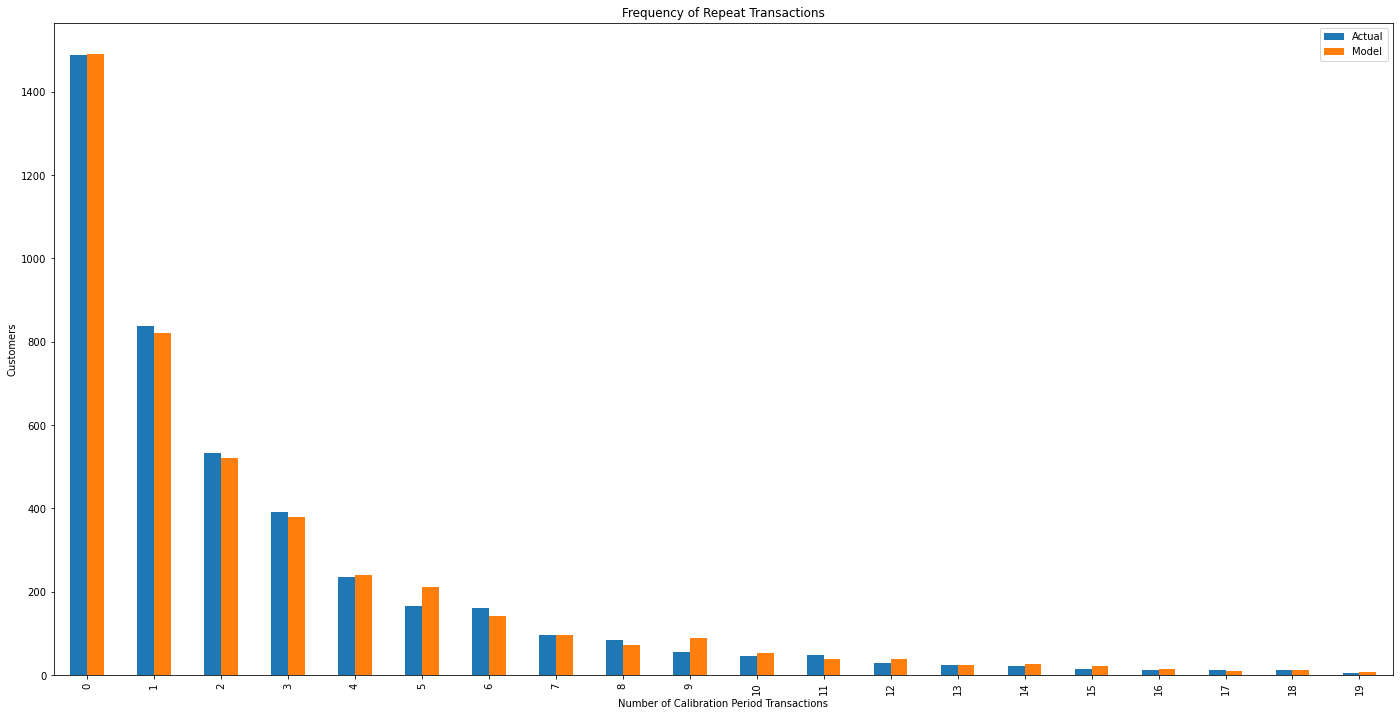

In [40]:
plot_period_transactions(bgf, max_frequency = 20, figsize=(24,12))

### 2) Cumulative Transaction Plot
#### Key Measurement: Does the model predict cumulative sales well?
- The plot uses the calibration period (training) to predict out-of-sample period (test). We prefer looking at a cumulative picture as opposed to week-to-week or daily because it smooths out all the ups and downs and noise. We want to see that our model generally captures the trend well. We can see that our model predicts cumulative purchases in and out of sample extremely well.

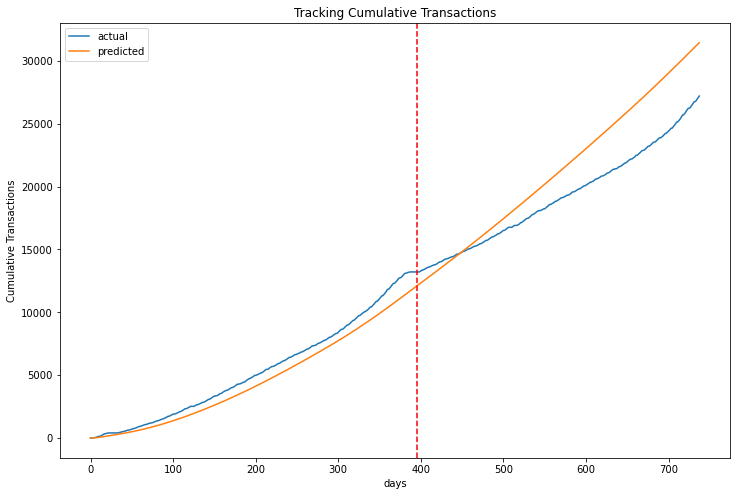

In [41]:
plot_cumulative_transactions(bgf, data, 'date', 'customer_id', 738, 395, freq  = 'D', xlabel = 'days', figsize=(12,8));

### 3) Incremental Transaction Plot
#### Key Measurement: Does the model capture the overall trend in transactions?
- In this chart we see the DTC promotions, we see market events, the ups and downs (i.e. seasonality), and in any given week, our model is terrible. Often what we see in Machine Learning models is that they'll tend to overfit trying to predict the ups and downs. However in the context of CLV, we don't care about noise, we care about capturing that overall baseline and being able to project over long periods of time. The other stuff is just temporary and transient things but not necessarily fundamental changes in behaviour. In this case we see a higher peak towards the end of Year 2 vs. Year 1. The predicted line follows suit by trending higher around that same period compared to previous year.

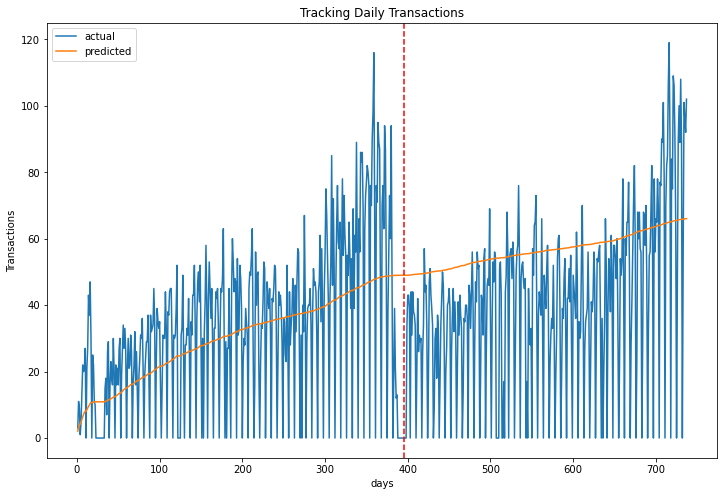

In [42]:
plot_incremental_transactions(bgf, data, 'date', 'customer_id', 738, 395, freq  = 'D', xlabel = 'days', figsize=(12,8));

### 4) Conditional Expectations Plot
#### Key Measurement: Can the model predict the number of purchases a customer will make based on the training data?
- Reminder: Calibration = Training, Holdout = Test
- This is arguably the most important plot. The wrong way to think about customer purchase behaviour would be to say if a customer purchased 3 times previously, then they must purchase 3 times in the future. This isn't always the case. Sales patterns always change
- This plot shows the actual number of purchases made in the calibration and holdout periods and plots it against the predicted purchases made in both periods
- If this chart is accurate, this gives us the ability to start drilling down and to start making different statements about our customers to say who are the good customers and who are the not so good customers and how important it is for us to be accurate about all of them
- The model does incredibly well at predicting using out-of-sample data.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

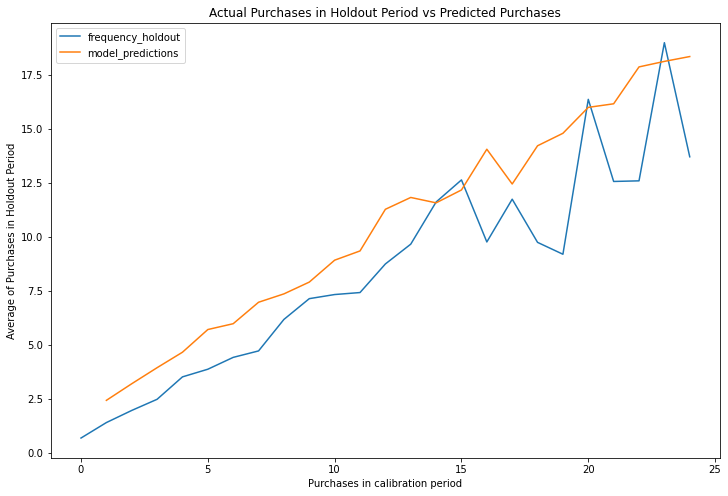

In [43]:
plot_calibration_purchases_vs_holdout_purchases(bgf, data_cal_holdout, n = 25, figsize=(12,8))

### Discussion on Predicting Transactions
- Up until now we've only predicted the number of transactions per customer, which looks to be very accurate according to our model. However, we haven't predicted their transaction values which will lead us to predicting their customer lifetime value. To do this, we'll need to use the Gamma-Gamma model

## 5. Predicting Customer Lifetime Value

- To predict CLV we'll need to remove customers who are one-time purchasers since it'll be really hard for our model to estimate customer who haven't had a repeat purchase. Our models will start calculating CLV upon their 1st repeat purchase. We also remove any records with negatives (i.e. returns) since our model cannot handle values below 0.

In [44]:
#Remove all one-time purchasers
returning_customers_summary = summary[summary['monetary_value']>0]

In [45]:
#Check the data
returning_customers_summary.head(10)

,frequency,recency,T,monetary_value,expected_purchases_endof2012
customer_id,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793
12347.0,7.0,402.0,404.0,717.398571,6.341063
12348.0,4.0,363.0,438.0,449.310000,3.641674
12349.0,3.0,571.0,589.0,1120.056667,2.231514
12352.0,8.0,356.0,392.0,338.261250,7.330727
12353.0,1.0,204.0,408.0,89.000000,1.428880
12355.0,1.0,353.0,567.0,459.400000,1.081346
12356.0,5.0,402.0,424.0,1092.648000,4.527911
12357.0,1.0,355.0,388.0,6207.670000,1.515600


- From this, we can see that customer 12347 made 7 repeat purchases, has a recency of 402 days and customer age of 404 days meaning they've been a customer for 404 days, and last purchased on the 402nd day meaning we've recently "seen" them. They're predicted to make ~6 purchases in the next year.

### Test for Independence
- When using the Gamma-Gamma model, there's an important assumption that there is no relationship between the customer's monetary value and frequency, that is, they are independent of each other
- Our pearson correlation test reveals that the correlation is very weak and therefore the assumptions holds and we can move forward

In [46]:
#Run Pearson Correlation
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.023223
frequency,0.023223,1.000000


In [47]:
#Initialize the Model
ggf = GammaGammaFitter(penalizer_coef = 0)

In [48]:
#Fit our GG model with Frequency and Monetary Value
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 2.13, q: 3.53, v: 486.53>

In [49]:
#The method is poorly named since profit implies a cost, here we are simply calculating a customer's average transaction value over the customer's lifetime
conditional_expected_sales = ggf.conditional_expected_average_profit(summary['frequency'], 
                                                                     summary['monetary_value'])
conditional_expected_sales.head(10)

customer_id
12346.0    9520.529482
12347.0     672.740683
12348.0     440.212758
12349.0     918.531323
12352.0     347.481829
12353.0     263.054511
12355.0     432.350492
12356.0     961.519741
12357.0    3059.669630
12358.0     567.432251
dtype: float64

In [50]:
#Calculate the average transaction value for our entire customer base
print("Average Transaction Value for each Customer:", "$", conditional_expected_sales.mean())

Average Transaction Value for each Customer: $ 436.5948688551693


In [51]:
#We're going to refit our model with our original summary data set now that we've proven it's out of sample accuracy
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4189 subjects, a: 0.10, alpha: 103.35, b: 0.97, r: 1.52>

In [52]:
#Compute each customer's lifetime value for the end of 2012 using 6% annual discount rate
returning_customers_summary['expected_clv_endof2012'] = ggf.customer_lifetime_value(bgf, 
                                  summary['frequency'], 
                                  summary['recency'], 
                                  summary['T'], 
                                  summary['monetary_value'],
                                time=12, 
                                discount_rate=0.01,                 
                                 )
returning_customers_summary.head(10)

,frequency,recency,T,monetary_value,expected_purchases_endof2012,expected_clv_endof2012
customer_id,,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793,16552.591131
12347.0,7.0,402.0,404.0,717.398571,6.341063,3644.411685
12348.0,4.0,363.0,438.0,449.310000,3.641674,1391.121371
12349.0,3.0,571.0,589.0,1120.056667,2.231514,1900.539146
12352.0,8.0,356.0,392.0,338.261250,7.330727,2132.064800
12353.0,1.0,204.0,408.0,89.000000,1.428880,309.168757
12355.0,1.0,353.0,567.0,459.400000,1.081346,420.580099
12356.0,5.0,402.0,424.0,1092.648000,4.527911,3791.558870
12357.0,1.0,355.0,388.0,6207.670000,1.515600,4533.929046


In [53]:
# Calculate probability of being currently alive and assign to each Customer
returning_customers_summary['p_alive'] = bgf.conditional_probability_alive(returning_customers_summary['frequency'], returning_customers_summary['recency'], returning_customers_summary['T'])

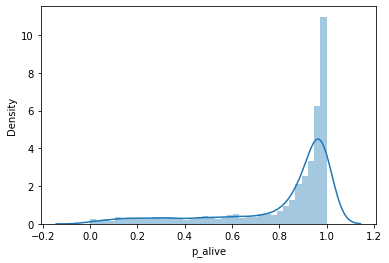

In [54]:
#plot the distribution of customers
#Most are active but there is a portion that is close to churning or have churned
sns.distplot(returning_customers_summary['p_alive']);

In [55]:
#Generate churn statistics
returning_customers_summary['churn'] = ['Churned' if p_alive < 0.5 else 'Not Churned' for p_alive in returning_customers_summary['p_alive']]
returning_customers_summary['churn'][(returning_customers_summary['p_alive'] >= 0.5) & (returning_customers_summary['p_alive'] < 0.75)] = "High Churn Risk"
returning_customers_summary['churn'].value_counts()

Not Churned        3178
Churned             608
High Churn Risk     403
Name: churn, dtype: int64

In [56]:
# Using the Gamma-Gamma model, we can estimate the average transaction value for each customer over their lifetime
returning_customers_summary['estimated_transaction_value'] = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

In [57]:
#see data
returning_customers_summary

,frequency,recency,T,monetary_value,expected_purchases_endof2012,expected_clv_endof2012,p_alive,churn,estimated_transaction_value
customer_id,,,,,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793,16552.591131,0.511190,High Churn Risk,9520.529482
12347.0,7.0,402.0,404.0,717.398571,6.341063,3644.411685,0.986002,Not Churned,672.740683
12348.0,4.0,363.0,438.0,449.310000,3.641674,1391.121371,0.947968,Not Churned,440.212758
12349.0,3.0,571.0,589.0,1120.056667,2.231514,1900.539146,0.964980,Not Churned,918.531323
12352.0,8.0,356.0,392.0,338.261250,7.330727,2132.064800,0.975974,Not Churned,347.481829
...,...,...,...,...,...,...,...,...,...
18281.0,1.0,397.0,577.0,80.820000,1.067985,258.066619,0.823701,Not Churned,259.315739
18282.0,1.0,119.0,126.0,77.840000,3.510399,800.725421,0.903575,Not Churned,257.953692
18283.0,18.0,655.0,658.0,146.405556,9.959148,1371.809606,0.994283,Not Churned,162.698126


In [58]:
#Calculate Total Customer Base Value
sum(returning_customers_summary['expected_clv_endof2012'])

8135544.828366573

In [59]:
#See Top 20 Customers by CLV
returning_customers_summary.sort_values('expected_clv_endof2012').tail(20)

,frequency,recency,T,monetary_value,expected_purchases_endof2012,expected_clv_endof2012,p_alive,churn,estimated_transaction_value
customer_id,,,,,,,,,
14088.0,13.0,411.0,421.0,3949.358462,10.818842,32860.405281,0.990339,Not Churned,3652.989559
15769.0,39.0,721.0,728.0,2223.700513,19.228861,34939.536304,0.996554,Not Churned,2170.078235
14298.0,44.0,720.0,728.0,2023.197500,21.642855,35832.236331,0.996633,Not Churned,1980.779238
12931.0,42.0,717.0,738.0,2171.127143,20.417962,36156.764093,0.993199,Not Churned,2122.675712
16029.0,70.0,693.0,731.0,1699.404857,33.987633,45929.774267,0.963073,Not Churned,1677.882046
15311.0,195.0,738.0,738.0,594.605846,93.394177,45959.229124,0.999510,Not Churned,593.485542
13089.0,131.0,735.0,737.0,888.318779,62.947175,46191.133060,0.998999,Not Churned,884.016667
17949.0,70.0,736.0,737.0,1668.029714,33.819343,46415.927336,0.998513,Not Churned,1647.030448
15061.0,67.0,735.0,738.0,2008.116119,32.346323,53384.968660,0.998179,Not Churned,1980.268407


### Customer-Level Analytics
- Retrieve a specific customer and see their purchasing history and potential to churn timeline

In [60]:
#Code to pull a specific user
t = 12 #predict purchases in 12 periods
individual = summary.iloc[1]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.1984070314625903

In [61]:
individual.head()

frequency                         7.000000
recency                         402.000000
T                               404.000000
monetary_value                  717.398571
expected_purchases_endof2012      6.341063
Name: 12347.0, dtype: float64

,invoice,stockcode,description,quantity,invoice_date,price,customer_id,country,total_sale,date
423892,529924,22698,PINK REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.70,2010-10-31
423893,529924,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.70,2010-10-31
423894,529924,20985,HEART CALCULATOR,12,2010-10-31 14:20:00,1.25,12347.0,Iceland,15.00,2010-10-31
423895,529924,22418,10 COLOUR SPACEBOY PEN,24,2010-10-31 14:20:00,0.85,12347.0,Iceland,20.40,2010-10-31
423896,529924,22422,TOOTHPASTE TUBE PEN,12,2010-10-31 14:20:00,0.65,12347.0,Iceland,7.80,2010-10-31
...,...,...,...,...,...,...,...,...,...,...
535010,581180,20719,WOODLAND CHARLOTTE BAG,10,2011-12-07 15:52:00,0.85,12347.0,Iceland,8.50,2011-12-07
535011,581180,21265,PINK GOOSE FEATHER TREE 60CM,12,2011-12-07 15:52:00,1.95,12347.0,Iceland,23.40,2011-12-07
535012,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,12347.0,Iceland,13.28,2011-12-07
535013,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,12347.0,Iceland,8.40,2011-12-07


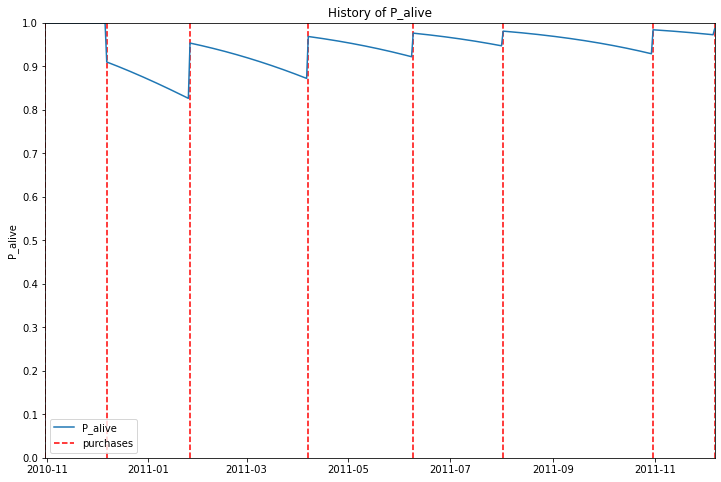

In [62]:
#See a customer's purchase history
customer_id = 12347
days_since_birth = 70
sp_trans = data.loc[data['customer_id'] == customer_id]
fig = plt.figure(figsize=(12,8))
plot_history_alive(bgf, days_since_birth, sp_trans, 'date', freq = 'D')
sp_trans

### RFM Segmentation
- Segment our customers by CLV

In [63]:
#Define quantiles. You can divide your customers into 4-5 or as many groups as it makes sense to have
quantiles = returning_customers_summary.quantile(q=[0.00,0.33,0.66])
quantiles = quantiles.to_dict()

In [64]:
segmented_rfm = returning_customers_summary

In [65]:
def RScore(x,p,d):
    if x <= d[p][0.00]:
        return 0
    elif x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]: 
        return 2
    else:
        return 3
    
def FMScore(x,p,d):
    if x <= d[p][0.00]:
        return 0
    elif x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]: 
        return 2
    else:
        return 3

In [66]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,frequency,recency,T,monetary_value,expected_purchases_endof2012,expected_clv_endof2012,p_alive,churn,estimated_transaction_value,r_quartile,f_quartile,m_quartile
customer_id,,,,,,,,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793,16552.591131,0.511190,High Churn Risk,9520.529482,2,3,3
12347.0,7.0,402.0,404.0,717.398571,6.341063,3644.411685,0.986002,Not Churned,672.740683,2,3,3
12348.0,4.0,363.0,438.0,449.310000,3.641674,1391.121371,0.947968,Not Churned,440.212758,2,2,3
12349.0,3.0,571.0,589.0,1120.056667,2.231514,1900.539146,0.964980,Not Churned,918.531323,3,2,3
12352.0,8.0,356.0,392.0,338.261250,7.330727,2132.064800,0.975974,Not Churned,347.481829,2,3,2


In [67]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,frequency,recency,T,monetary_value,expected_purchases_endof2012,expected_clv_endof2012,p_alive,churn,estimated_transaction_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_id,,,,,,,,,,,,,
12346.0,7.0,400.0,725.0,11066.637143,3.603793,16552.591131,0.511190,High Churn Risk,9520.529482,2,3,3,233
12347.0,7.0,402.0,404.0,717.398571,6.341063,3644.411685,0.986002,Not Churned,672.740683,2,3,3,233
12348.0,4.0,363.0,438.0,449.310000,3.641674,1391.121371,0.947968,Not Churned,440.212758,2,2,3,223
12349.0,3.0,571.0,589.0,1120.056667,2.231514,1900.539146,0.964980,Not Churned,918.531323,3,2,3,323
12352.0,8.0,356.0,392.0,338.261250,7.330727,2132.064800,0.975974,Not Churned,347.481829,2,3,2,232


In [68]:
#Export for Analysis
segmented_rfm.to_csv(r'/Users/williamchan/Documents/Queens University /Chanalytics/CLV/Data/segmented_rfm.csv')